# Scenario Testing BHC Module

In [59]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy import linalg as la
from scipy import random as rnd
from scipy.special import gamma
import matplotlib.pyplot as plt
from sklearn import datasets as data
from sklearn import metrics

# load our package
import bhc

## Metrics

In [60]:
def purity_score(y_true, y_pred):
    """
    Inputs:
    y_true - an array of the true cluster assignments of type int
    y_pred - an array of the predicted cluster assignments of type int
    
    Output:
    Cluster purity metric (range [0,1]) for the cluster assignments 
    relative to their true values.
    
    Reference:
    https://en.wikipedia.org/wiki/Cluster_analysis#Evaluation_and_assessment
    """
    
    from sklearn import metrics
    
    # build confusion matrix
    conf_mat = metrics.cluster.contingency_matrix(y_true, y_pred)
    #print(conf_mat)
    
    # calculate score
    score = np.sum(np.amax(conf_mat, axis=0))/np.sum(conf_mat)
    
    return np.round(score,2)

In [61]:
def adj_purity_score(y_true, y_pred, n_clust_true):
    """
    Inputs:
    y_true - an array of the true cluster assignments of type int
    y_pred - an array of the predicted cluster assignments of type int
    n_clust_true - int, the true number of classes in the data 
    
    Output:
    Cluster purity metric (range [0,1]) for the cluster assignments 
    relative to their true values.
    
    Reference:
    https://en.wikipedia.org/wiki/Cluster_analysis#Evaluation_and_assessment
    """
    
    from sklearn import metrics
    
    # build confusion matrix
    conf_mat = metrics.cluster.contingency_matrix(y_true, y_pred)
    
    # find max number of points for each class
    class_max = np.amax(conf_mat, axis=0)
    class_max.sort()
    # calculate score
    score = np.sum(class_max[::-1][0:n_clust_true])/np.sum(conf_mat)
    
    return np.round(score,2)

In [62]:
test= np.array([[1,2,3,4,5],[0,3,1,2,8]])
max_test = test.max(axis=0)
max_test.sort()
max_test[::-1][0:3]

array([8, 4, 3])

## Three component Gaussian mixture (simulated data set):

In [63]:
n_dim = 3 # dimensionality of problem

# bivariate gaussian params
mu1 = np.zeros(3)
cov1 = np.eye(3)

mu2 = np.array([5, 3, 0])
cov2 = np.eye(3)

mu3 = np.array([8, 12, 1])
cov3 = np.eye(3)* 0.5

# multinom params
p1 = 0.3
p2 = 0.4
p3 = 1 - p2 - p1

# number of total draws
draws = 100

In [64]:
# random draws
rnd.seed(1)

knum = rnd.multinomial(draws, (p1, p2, p3))

gaus1 = rnd.multivariate_normal(mu1, cov1, knum[0])
gaus2 = rnd.multivariate_normal(mu2, cov2, knum[1])
gaus3 = rnd.multivariate_normal(mu3, cov3, knum[2])

# join columns into dataframe
x1 = pd.Series(np.r_[gaus1[:, 0], gaus2[:, 0], gaus3[:, 0]])
x2 = pd.Series(np.r_[gaus1[:, 1], gaus2[:, 1], gaus3[:, 1]])
x3 = pd.Series(np.r_[gaus1[:, 2], gaus2[:, 2], gaus3[:, 2]])
c = pd.Series(np.r_[np.zeros(knum[0]), np.ones(knum[1]), np.ones(knum[2]) * 2])
dat = {"x1" : x1, "x2" : x2, "x3" : x3, "c" : c}
clustData = pd.DataFrame(dat)

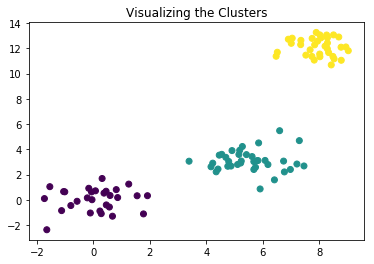

In [65]:
plt.scatter(clustData["x1"], clustData["x2"], c = clustData["c"])
plt.title("Visualizing the Clusters")
plt.show()

### Using BHC

In [66]:
# standardize data
clustData_std = (clustData.values[:, :3] - 
                 clustData.values[:, :3].mean(axis = 0))/(clustData.values[:, :3].std(axis=0))
clustData_std.mean(axis=0)

array([ 9.32587341e-17, -1.77635684e-17,  2.83106871e-17])

In [67]:
# priors distribution hyper-parameters
gcPriors = {
    "clusterConcentrationPrior" : {"alpha" : 0.0001},
    "diffuseInvWishPrior" : {"df" : 3, "scale" : np.eye(3)}, # inv wishart params
    "diffuseNormPrior" : {"loc" : clustData.values[:, :3].mean(axis=0),
                          "scale" : np.eye(3),
                          "meanscale" : 1}, # mvtnormal params
}

In [68]:
gc = clustData.values[:, :3] #clustData_std
gctree = bhc.HierarchyTree(X = gc, allParams = gcPriors)

In [69]:
gctree.grow_tree()

In [70]:
# pre prunning tree summary
gctree.tree_summary()

Summary for tier 16:
-------------------------------
Number of clusters: 1
  Cluster 0 size: 100.0
	 Posterior merge probability: 0.0


Summary for tier 15:
-------------------------------
Number of clusters: 1
  Cluster 0 size: 88.0
	 Posterior merge probability: 0.0


Summary for tier 14:
-------------------------------
Number of clusters: 1
  Cluster 0 size: 76.0
	 Posterior merge probability: 0.0


Summary for tier 13:
-------------------------------
Number of clusters: 1
  Cluster 0 size: 62.0
	 Posterior merge probability: 0.0


Summary for tier 12:
-------------------------------
Number of clusters: 1
  Cluster 0 size: 24.0
	 Posterior merge probability: 1.0


Summary for tier 11:
-------------------------------
Number of clusters: 1
  Cluster 0 size: 22.0
	 Posterior merge probability: 1.0


Summary for tier 10:
-------------------------------
Number of clusters: 1
  Cluster 0 size: 20.0
	 Posterior merge probability: 1.0


Summary for tier 9:
-------------------------------
Nu

In [71]:
gctree.prune_tree()

In [72]:
gctree.tree_summary()

Summary for tier 16:
-------------------------------
Number of clusters: 1
  Cluster 0 size: 12.0
	 Posterior merge probability: 1.0


Summary for tier 15:
-------------------------------
Number of clusters: 1
  Cluster 0 size: 12.0
	 Posterior merge probability: 1.0


Summary for tier 14:
-------------------------------
Number of clusters: 1
  Cluster 0 size: 14.0
	 Posterior merge probability: 1.0


Summary for tier 13:
-------------------------------
Number of clusters: 1
  Cluster 0 size: 24.0
	 Posterior merge probability: 1.0


Summary for tier 12:
-------------------------------
Number of clusters: 1
  Cluster 0 size: 24.0
	 Posterior merge probability: 1.0


Summary for tier 11:
-------------------------------
Number of clusters: 1
  Cluster 0 size: 22.0
	 Posterior merge probability: 1.0


Summary for tier 10:
-------------------------------
Number of clusters: 1
  Cluster 0 size: 20.0
	 Posterior merge probability: 1.0


Summary for tier 9:
-------------------------------
Num

In [73]:
gctree.generate_clust_frame()

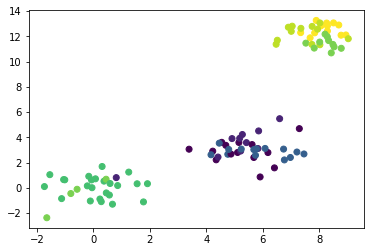

In [74]:
plt.scatter("Dim_0", "Dim_1", c = "clustnum", data=gctree.clustDF)
plt.show()

In [75]:
purity_score(clustData["c"], gctree.clustDF["clustnum"])

0.95

In [76]:
adj_purity_score(clustData["c"], gctree.clustDF["clustnum"], n_dim)

0.52

### Using sklearn hierarchical clustering

In [77]:
from sklearn.cluster import AgglomerativeClustering

In [78]:
gc_tree_cv = []
for n_clust in range(1,10):
    gc_tree1 = AgglomerativeClustering(n_clusters = n_clust)
    gc_tree1.fit(gc)
    gc_tree_cv.append((n_clust, 
                       purity_score(clustData["c"], gc_tree1.labels_),
                       adj_purity_score(clustData["c"], gc_tree1.labels_, n_dim)
                      ))

In [79]:
gc_tree_cv

[(1, 0.37, 0.37),
 (2, 0.71, 0.71),
 (3, 1.0, 1.0),
 (4, 1.0, 0.86),
 (5, 1.0, 0.78),
 (6, 1.0, 0.72),
 (7, 1.0, 0.69),
 (8, 1.0, 0.55),
 (9, 1.0, 0.48)]

### Using k-means clustering

In [80]:
from sklearn.cluster import k_means

In [81]:
gc_kmeans_cv = []
for n_clust in range(1,10):
    centr, km_labs, inert = k_means(gc, n_clusters = n_clust)
    gc_kmeans_cv.append((n_clust, 
                         purity_score(clustData["c"], km_labs),
                         adj_purity_score(clustData["c"], km_labs, n_dim)
                        ))

In [82]:
gc_kmeans_cv

[(1, 0.37, 0.37),
 (2, 0.71, 0.71),
 (3, 1.0, 1.0),
 (4, 1.0, 0.85),
 (5, 1.0, 0.71),
 (6, 1.0, 0.65),
 (7, 1.0, 0.59),
 (8, 1.0, 0.54),
 (9, 1.0, 0.51)]

In [150]:
bhc_synth = (purity_score(clustData["c"], gctree.clustDF["clustnum"]), adj_purity_score(clustData["c"], gctree.clustDF["clustnum"], n_dim))

In [155]:
synth_res = np.array([
    bhc_synth,
    np.mean(gc_tree_cv, axis=0)[1::],
    np.mean(gc_kmeans_cv, axis=0)[1::]
])

## Computational Speed

In [83]:
%%timeit -r3 -n3
gctree = bhc.HierarchyTree(X = gc, allParams = gcPriors)
gctree.grow_tree()

33.1 s ± 246 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [84]:
%%timeit -r3 -n3
gc_tree1 = AgglomerativeClustering(n_clusters = 10)
gc_tree1.fit(gc)

968 µs ± 219 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [85]:
%%timeit -r3 -n3
centr, km_labs, inert = k_means(gc, n_clusters = 10)

26.5 ms ± 2.71 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


## Iris data

In [86]:
iris = data.load_iris()

In [87]:
iris.data.shape

(150, 4)

In [88]:
n_dim_iris = np.unique(iris.target).shape[0]
n_dim_iris

3

In [89]:
np.unique(iris.target)

array([0, 1, 2])

In [90]:
# standardize data
iris_data_std = (iris.data - iris.data.mean(axis=0))/(iris.data.std(axis=0))

### Using BHC

In [91]:
k = iris.data.shape[1]
# priors distribution hyper-parameters
irisPriors = {
    "clusterConcentrationPrior" : {"alpha" : 0.0001},
    "diffuseInvWishPrior" : {"df" : 4, "scale" : np.eye(k)}, # inv wishart params
    "diffuseNormPrior" : {"loc" : iris_data_std.mean(axis = 0),
                          "scale" : np.eye(k),
                          "meanscale" : 1}, # mvtnormal params
}

In [92]:
iris_tree = bhc.HierarchyTree(X = iris_data_std, allParams = irisPriors)

In [93]:
iris_tree.grow_tree()

In [94]:
iris_tree.tree_summary()

Summary for tier 18:
-------------------------------
Number of clusters: 1
  Cluster 0 size: 150.0
	 Posterior merge probability: 0.0


Summary for tier 17:
-------------------------------
Number of clusters: 1
  Cluster 0 size: 116.0
	 Posterior merge probability: 0.0


Summary for tier 16:
-------------------------------
Number of clusters: 1
  Cluster 0 size: 82.0
	 Posterior merge probability: 0.0


Summary for tier 15:
-------------------------------
Number of clusters: 1
  Cluster 0 size: 50.0
	 Posterior merge probability: 0.0


Summary for tier 14:
-------------------------------
Number of clusters: 1
  Cluster 0 size: 30.0
	 Posterior merge probability: 1.0


Summary for tier 13:
-------------------------------
Number of clusters: 1
  Cluster 0 size: 28.0
	 Posterior merge probability: 1.0


Summary for tier 12:
-------------------------------
Number of clusters: 1
  Cluster 0 size: 26.0
	 Posterior merge probability: 1.0


Summary for tier 11:
-------------------------------


In [95]:
iris_tree.prune_tree()

In [96]:
iris_tree.tree_summary()

Summary for tier 18:
-------------------------------
Number of clusters: 1
  Cluster 0 size: 34.0
	 Posterior merge probability: 1.0


Summary for tier 17:
-------------------------------
Number of clusters: 1
  Cluster 0 size: 34.0
	 Posterior merge probability: 1.0


Summary for tier 16:
-------------------------------
Number of clusters: 1
  Cluster 0 size: 32.0
	 Posterior merge probability: 1.0


Summary for tier 15:
-------------------------------
Number of clusters: 2
  Cluster 0 size: 30.0
	 Posterior merge probability: 1.0
  Cluster 1 size: 20.0
	 Posterior merge probability: 1.0


Summary for tier 14:
-------------------------------
Number of clusters: 1
  Cluster 0 size: 30.0
	 Posterior merge probability: 1.0


Summary for tier 13:
-------------------------------
Number of clusters: 1
  Cluster 0 size: 28.0
	 Posterior merge probability: 1.0


Summary for tier 12:
-------------------------------
Number of clusters: 1
  Cluster 0 size: 26.0
	 Posterior merge probability: 1.0

In [97]:
iris_tree.generate_clust_frame()
purity_score(iris.target, iris_tree.clustDF["clustnum"])

0.53

In [98]:
adj_purity_score(iris.target, iris_tree.clustDF["clustnum"], n_dim_iris)

0.35

### Using sklearn hierarchical clustering

In [99]:
iris_tree1_cv = []
for n_clust in range(1,10):
    iris_tree1 = AgglomerativeClustering(n_clusters = n_clust)
    iris_tree1.fit(iris_data_std)
    iris_tree1_cv.append((n_clust, 
                       purity_score(iris.target, iris_tree1.labels_),
                       adj_purity_score(iris.target, iris_tree1.labels_, n_dim_iris)
                      ))

In [100]:
iris_tree1_cv

[(1, 0.33, 0.33),
 (2, 0.66, 0.66),
 (3, 0.83, 0.83),
 (4, 0.83, 0.68),
 (5, 0.83, 0.59),
 (6, 0.83, 0.57),
 (7, 0.83, 0.55),
 (8, 0.83, 0.55),
 (9, 0.89, 0.53)]

### Using k-means clustering

In [101]:
iris_kmeans_cv = []
for n_clust in range(1,10):
    centr, km_labs, inert = k_means(iris_data_std, n_clusters = n_clust)
    iris_kmeans_cv.append((n_clust, 
                         purity_score(iris.target, km_labs),
                         adj_purity_score(iris.target, km_labs, n_dim_iris)
                        ))

In [102]:
iris_kmeans_cv

[(1, 0.33, 0.33),
 (2, 0.67, 0.67),
 (3, 0.83, 0.83),
 (4, 0.85, 0.69),
 (5, 0.85, 0.56),
 (6, 0.83, 0.49),
 (7, 0.83, 0.42),
 (8, 0.93, 0.45),
 (9, 0.94, 0.38)]

In [156]:
iris_synth = (purity_score(iris.target, iris_tree.clustDF["clustnum"]), 
              adj_purity_score(iris.target, iris_tree.clustDF["clustnum"], n_dim_iris))

In [159]:
iris_res = np.array([
    iris_synth,
    np.mean(iris_tree1_cv, axis=0)[1::],
    np.mean(iris_kmeans_cv, axis=0)[1::]
])

iris_res

array([[0.53      , 0.35      ],
       [0.76222222, 0.58777778],
       [0.78444444, 0.53555556]])

## Wine data

In [103]:
wine = data.load_wine()

In [104]:
wine.data.shape

(178, 13)

In [105]:
n_dim_wine = np.unique(wine.target).shape[0]
n_dim_wine

3

### Using BHC

In [106]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [107]:
# standardize data
wine_data_std = (wine.data - wine.data.mean(axis=0))/(wine.data.std(axis=0))

In [108]:
wine_pca = PCA(n_components = 3)
wine_red = wine_pca.fit_transform(wine_data_std, wine.target)

In [109]:
wine_red.shape

(178, 3)

In [110]:
wine_pca.explained_variance_ratio_

array([0.36198848, 0.1920749 , 0.11123631])

In [111]:
wine_train, wine_test, target_train, target_test = train_test_split(wine_red, wine.target, test_size= 0.1)

In [112]:
k = wine_red.shape[1]
# priors distribution hyper-parameters
winePriors = {
    "clusterConcentrationPrior" : {"alpha" : 0.0001},
    "diffuseInvWishPrior" : {"df" : k, "scale" : np.eye(k)}, # inv wishart params
    "diffuseNormPrior" : {"loc" : wine_red.mean(axis = 0),
                          "scale" : np.eye(k),
                          "meanscale" : 1}, # mvtnormal params
}

In [113]:
wine_tree = bhc.HierarchyTree(X = wine_train, allParams = winePriors)

In [114]:
wine_tree.grow_tree()

In [115]:
wine_tree.tree_summary()

Summary for tier 16:
-------------------------------
Number of clusters: 1
  Cluster 0 size: 160.0
	 Posterior merge probability: 0.0


Summary for tier 15:
-------------------------------
Number of clusters: 1
  Cluster 0 size: 138.0
	 Posterior merge probability: 0.0


Summary for tier 14:
-------------------------------
Number of clusters: 1
  Cluster 0 size: 116.0
	 Posterior merge probability: 0.0


Summary for tier 13:
-------------------------------
Number of clusters: 1
  Cluster 0 size: 96.0
	 Posterior merge probability: 0.0


Summary for tier 12:
-------------------------------
Number of clusters: 1
  Cluster 0 size: 70.0
	 Posterior merge probability: 0.0


Summary for tier 11:
-------------------------------
Number of clusters: 2
  Cluster 0 size: 26.0
	 Posterior merge probability: 1.0
  Cluster 1 size: 46.0
	 Posterior merge probability: 0.0


Summary for tier 10:
-------------------------------
Number of clusters: 4
  Cluster 0 size: 24.0
	 Posterior merge probability: 

In [116]:
wine_tree.prune_tree()

In [117]:
wine_tree.generate_clust_frame()
purity_score(target_train, wine_tree.clustDF["clustnum"])

0.42

In [118]:
adj_purity_score(target_train, wine_tree.clustDF["clustnum"], n_dim_wine)

0.19

### Using sklearn hierarchical clustering

In [119]:
wine_tree1_cv = []
for n_clust in range(1,10):
    wine_tree1 = AgglomerativeClustering(n_clusters = n_clust)
    wine_tree1.fit(wine_train)
    wine_tree1_cv.append((n_clust, 
                       purity_score(target_train, wine_tree1.labels_),
                       adj_purity_score(target_train, wine_tree1.labels_, n_dim_wine)
                      ))

In [120]:
wine_tree1_cv

[(1, 0.39, 0.39),
 (2, 0.62, 0.62),
 (3, 0.86, 0.86),
 (4, 0.88, 0.78),
 (5, 0.88, 0.68),
 (6, 0.88, 0.68),
 (7, 0.88, 0.54),
 (8, 0.88, 0.45),
 (9, 0.91, 0.44)]

### Using k-means clustering

In [121]:
wine_kmeans_cv = []
for n_clust in range(1,10):
    centr, km_labs, inert = k_means(wine_train, n_clusters = n_clust)
    wine_kmeans_cv.append((n_clust, 
                         purity_score(target_train, km_labs),
                         adj_purity_score(target_train, km_labs, n_dim_wine)
                        ))

In [138]:
wine_kmeans_cv

[(1, 0.39, 0.39),
 (2, 0.61, 0.61),
 (3, 0.97, 0.97),
 (4, 0.96, 0.79),
 (5, 0.93, 0.78),
 (6, 0.94, 0.65),
 (7, 0.91, 0.56),
 (8, 0.91, 0.48),
 (9, 0.91, 0.51)]

In [160]:
wine_synth = (purity_score(target_train, wine_tree.clustDF["clustnum"]),
             adj_purity_score(target_train, wine_tree.clustDF["clustnum"], n_dim_wine))

In [162]:
wine_res = np.array([
    wine_synth,
    np.mean(wine_tree1_cv, axis=0)[1::],
    np.mean(wine_kmeans_cv, axis=0)[1::]
])

wine_res

array([[0.42      , 0.19      ],
       [0.79777778, 0.60444444],
       [0.83666667, 0.63777778]])

## Testing binomial

In [123]:
n_dim = 3 # dimensionality of problem

# bernoulii params
mu1 = 0
mu2 = 0.3
mu3 = 1

# multinom params
p1 = 0.4
p2 = 0.1
p3 = 1 - p2 - p1

# number of total draws
draws = 100

# random draws
rnd.seed(1)

knum = rnd.multinomial(draws, (p1, p2, p3))

bern1 = rnd.binomial(1, mu1, knum[0])
bern2 = rnd.binomial(1, mu2, knum[1])
bern3 = rnd.binomial(1, mu2, knum[2])

# join columns into dataframe
x1 = pd.Series(np.r_[bern1, bern2, bern3])
x2 = pd.Series(np.r_[bern1, bern2, bern3])
x3 = pd.Series(np.r_[bern1, bern2, bern3])
c = pd.Series(np.r_[np.zeros(knum[0]), np.ones(knum[1]), np.ones(knum[2]) * 2])
dat = {"x1" : x1, "x2" : x2, "x3" : x3, "c" : c}
bernData = pd.DataFrame(dat)

### Using BHC

In [124]:
# priors distribution hyper-parameters
bernPriors = {
    "clusterConcentrationPrior" : {"alpha" : 0.0001},
    "alphaPrior" : {"succ" : 1},
    "betaPrior" : {"fail" : 1}
}

In [125]:
bern_train = bernData.values[:, :3]
bern_tree = bhc.HierarchyTree(X = bern_train, allParams = bernPriors, family="beta-bern")

In [126]:
bern_tree.grow_tree()

In [127]:
bern_tree.tree_summary()

Summary for tier 26:
-------------------------------
Number of clusters: 1
  Cluster 0 size: 100.0
	 Posterior merge probability: 1.0


Summary for tier 25:
-------------------------------
Number of clusters: 1
  Cluster 0 size: 96.0
	 Posterior merge probability: 1.0


Summary for tier 24:
-------------------------------
Number of clusters: 1
  Cluster 0 size: 92.0
	 Posterior merge probability: 1.0


Summary for tier 23:
-------------------------------
Number of clusters: 1
  Cluster 0 size: 88.0
	 Posterior merge probability: 1.0


Summary for tier 22:
-------------------------------
Number of clusters: 1
  Cluster 0 size: 84.0
	 Posterior merge probability: 1.0


Summary for tier 21:
-------------------------------
Number of clusters: 1
  Cluster 0 size: 80.0
	 Posterior merge probability: 1.0


Summary for tier 20:
-------------------------------
Number of clusters: 1
  Cluster 0 size: 76.0
	 Posterior merge probability: 1.0


Summary for tier 19:
-------------------------------
N

In [128]:
bern_tree.prune_tree()

In [129]:
bern_tree.tree_summary()

Summary for tier 26:
-------------------------------
Number of clusters: 1
  Cluster 0 size: 100.0
	 Posterior merge probability: 1.0


Summary for tier 25:
-------------------------------
Number of clusters: 1
  Cluster 0 size: 96.0
	 Posterior merge probability: 1.0


Summary for tier 24:
-------------------------------
Number of clusters: 1
  Cluster 0 size: 92.0
	 Posterior merge probability: 1.0


Summary for tier 23:
-------------------------------
Number of clusters: 1
  Cluster 0 size: 88.0
	 Posterior merge probability: 1.0


Summary for tier 22:
-------------------------------
Number of clusters: 1
  Cluster 0 size: 84.0
	 Posterior merge probability: 1.0


Summary for tier 21:
-------------------------------
Number of clusters: 1
  Cluster 0 size: 80.0
	 Posterior merge probability: 1.0


Summary for tier 20:
-------------------------------
Number of clusters: 1
  Cluster 0 size: 76.0
	 Posterior merge probability: 1.0


Summary for tier 19:
-------------------------------
N

In [130]:
bern_tree.generate_clust_frame()
purity_score(bernData["c"], bern_tree.clustDF["clustnum"])

0.55

In [131]:
adj_purity_score(bernData["c"], bern_tree.clustDF["clustnum"],3)

0.55

### Using sklearn hierarchical clustering

In [132]:
bern_tree1_cv = []
for n_clust in range(1,10):
    bern_tree1 = AgglomerativeClustering(n_clusters = n_clust)
    bern_tree1.fit(bern_train)
    bern_tree1_cv.append((n_clust, 
                       purity_score(bernData["c"], bern_tree.clustDF["clustnum"]),
                       adj_purity_score(bernData["c"], bern_tree.clustDF["clustnum"], 3)
                      ))

In [133]:
bern_tree1_cv

[(1, 0.55, 0.55),
 (2, 0.55, 0.55),
 (3, 0.55, 0.55),
 (4, 0.55, 0.55),
 (5, 0.55, 0.55),
 (6, 0.55, 0.55),
 (7, 0.55, 0.55),
 (8, 0.55, 0.55),
 (9, 0.55, 0.55)]

### Using k-means

In [134]:
bern_kmeans_cv = []
for n_clust in range(1,10):
    centr, km_labs, inert = k_means(bern_train, n_clusters = n_clust)
    bern_kmeans_cv.append((n_clust, 
                         purity_score(bernData["c"], bern_tree.clustDF["clustnum"]),
                         adj_purity_score(bernData["c"], bern_tree.clustDF["clustnum"], n_dim)
                        ))

In [135]:
bern_kmeans_cv

[(1, 0.55, 0.55),
 (2, 0.55, 0.55),
 (3, 0.55, 0.55),
 (4, 0.55, 0.55),
 (5, 0.55, 0.55),
 (6, 0.55, 0.55),
 (7, 0.55, 0.55),
 (8, 0.55, 0.55),
 (9, 0.55, 0.55)]

In [165]:
bern_synth = (purity_score(bernData["c"], bern_tree.clustDF["clustnum"]),
               adj_purity_score(bernData["c"], bern_tree.clustDF["clustnum"],3)
)

In [167]:
bern_res = np.array([
    binom_synth,
    np.mean(bern_tree1_cv, axis=0)[1::],
    np.mean(bern_kmeans_cv, axis=0)[1::]
])

bern_res

array([[0.55, 0.55],
       [0.55, 0.55],
       [0.55, 0.55]])

In [176]:
pd.DataFrame(np.round(np.column_stack((synth_res, iris_res, wine_res, bern_res)),2),
            index = ["BHC", "AHC", "K-means"],
            columns = ["Gaussian Purity", "Gaussian Adj", 
                       "Iris Purity", "Iris Adj", 
                       "Wine Purity", "Wine Adj",
                      "Bern Purity", "Bern Adj"])

,Gaussian Purity,Gaussian Adj,Iris Purity,Iris Adj,Wine Purity,Wine Adj,Bern Purity,Bern Adj
BHC,0.95,0.52,0.53,0.35,0.42,0.19,0.55,0.55
AHC,0.90,0.68,0.76,0.59,0.80,0.60,0.55,0.55
K-means,0.90,0.66,0.78,0.54,0.84,0.64,0.55,0.55
